# **CMI: Behavior Detection Model 1D-CNN 🧠** 

This is my full solution for the Child Mind Institute "Detect Behavior with Sensor Data" Kaggle competition, [which is linked here](https://www.kaggle.com/competitions/cmi-detect-behavior-with-sensor-data)

***

**✎  Overview:**

Have you ever wondered what makes someone tick? How about, what *is* a tick? This interesting problem from the Child Mind Institute asks us to investigate Body-Focused Repetitive Behaviors (BFRBs) such as nail-biting, hair-pulling and skin-picking, in an effort to better understand how they relate to Obsessive Compulsive Disorder (OCD). 

In a month-long research study conducted by the institute, 81 subjects were given a wrist device (developed by CMI, called "Helios") to wear for an extended period of time. While wearing the device, they were instructed to perform 18 different gestures from 1-4 sitting positions including sitting, sitting while leaning forward with their non-dominant arm resting on their leg, lying on their back, and lying on their side. [Gesture example video](https://youtu.be/WJVFUSJm4As?si=2XfSJGNk4j3Lja4D)


**✎  Data and Task:**

Among these gestures, there were 8 gestures classified as "BRFB-like", and 10 gestures classified as "non-BFRB-like", where BFRB-like gestures being linked to OCD.

With this competition, the Child Mind Institute has tasked the Kaggle-verse with building a predictive machine learning model that correctly identifies and labels sequences of observations as one of these 18 gestures. This time series data, recorded with the Helios device, is made up of sequences with 50-700 observations each, with observations being recorded at 10 Hz.

The Helios device recorded 3D acceleration data (in x/y/z directions), orientation data (with w/x/y/z quaternions), temperature, as well as 5 sets of "time-of-flight" data (we'll explore this in greater detail later). The acceleration and orientation components are a cateogry of observation commonly referred to as Inertial Measurement Units (IMU), and I will refer to them this way throughout this notebook. If you'd like to read more about the specific sensors used in this study, you can do so here:

- [Accelerometer](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/IMU_Sensor.pdf)
- [Temperature](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Thermopile_Sensor.pdf)
- [Time-of-Flight](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Time_of_Flight_Sensor.pdf)


**✎  Gestures:**

*BFRB:*
Above ear - Pull hair, Forehead - Pull hairline, Forehead - Scratch, Eyebrow - Pull hair, Eyelash - Pull hair, Neck - Pinch skin, Neck - Scratch, Cheek - Pinch skin

*non-BFRB:*
Drink from bottle/cup, Glasses on/off, Pull air toward your face, Pinch knee/leg skin, Scratch knee/leg skin, Write name on leg, Text on phone, Feel around in tray and pull out an object, Write name in air, Wave hello


## ✨ Let's begin! ✨

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from matplotlib.ticker import PercentFormatter
from matplotlib.cm import viridis
from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial.transform import Rotation as R

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

I have designed a color palette to apply to the tables in this EDA to make them more readable and give them a little bit more **pop!✨**

In [2]:
# custom yellow-orange-bronze color palette
def apply_gold_standard_style(styler):
    styler.background_gradient(cmap='YlOrBr', low=0, high=1, subset=num_cols)
    styler.format('{:.2f}', subset=num_cols)
    styler.set_properties(subset=cat_cols, **{'color': 'black', 'background-color': 'white'})
    styler.set_properties(**{'text-align': 'center', 'font-size': '12px', 'border': '1px solid white'})
    styler.set_table_styles([{'selector': 'th', 'props': [('background-color', '#ffd700'),
        ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('font-size', '14px'),
        ('border', '1px solid white')]}])
    return styler

In [3]:
# load train data
train_placeholder = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")
train = train_placeholder.copy()

print(f"Train shape: {train.shape}")
num_cols = train.select_dtypes(include='number').columns
cat_cols = train.select_dtypes(exclude='number').columns
display(train.head().style.pipe(apply_gold_standard_style))

Train shape: (574945, 341)


### Time-of-Flight Data:

Here we can see that the darkness of the yellow corresponds to the relative size of the values within each column, and gives a visual indicator for how the data is changing between observations. Scrolling to the right will reveal just how many "TOF" columns there are in this dataset, 320 in total. 

These 320 columns are split into 5 groups of 64, each of which could be thought of as an 8x8 grid of pixels, with each observation corresponding to a pixel. The value of each observation measures the perpendicular distance between that pixel on the surface of the wrist-device and the nearest physical surface/object/person, ranging on a relative sale for non-missing values from 0-254. So essentially, this data creates 5 depth-maps, giving robust context for the subject's physical surroundings.

![TOF diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F26856272%2F4efb2102b438d83fb3a65e135acaa14b%2FHelios_ToF_Grid_Fig.jpg?generation=1747669734957727&alt=media)

In addition to the sensor data, we also see some categorical indicator columns. Most of these just have to do with maintaining the structure of the dataset and will not be used in training, but some are interesting to investigate further. For example, the "phase" column separates each sequence into "transition" (transitioning into the gesture) and "gesture" (actually performing the gesture), and the "behavior" column further separates each sequence into "relaxes and moves hand to target location", "hand at target location", and "performs gesture".

In [4]:
# load train demographics data
train_demo = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")

print(f"Train Demographics shape: {train_demo.shape}")
num_cols = train_demo.select_dtypes(include='number').columns
cat_cols = train_demo.select_dtypes(exclude='number').columns
display(train_demo.head().style.pipe(apply_gold_standard_style))

Train Demographics shape: (81, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1.00,41.00,1.00,1.00,172.00,50.00,25.00
1,SUBJ_001430,0.00,11.00,0.00,1.00,167.00,51.00,27.00
2,SUBJ_002923,1.00,28.00,1.00,0.00,164.00,54.00,26.00
3,SUBJ_003328,1.00,33.00,1.00,1.00,171.00,52.00,25.00
4,SUBJ_004117,0.00,15.00,0.00,1.00,184.00,54.00,28.00


We've also been provided a separate demographics dataset that records some basic etrics about each subject in the study.

Most of this is not that important (since we aren't going to be training on it), but notice the "handedness" column - here "1" means right-handed and "0" means left-handed". Which arm the subject is wearing the device on completely flips our data so we'll take this into account further down.

In [5]:
# load test data
test = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv")

print(f"Test shape: {test.shape}")
num_cols = test.select_dtypes(include='number').columns
cat_cols = test.select_dtypes(exclude='number').columns
display(test.head().style.pipe(apply_gold_standard_style))

Test shape: (107, 336)


The test dataset (the dataset that we will be evaluating the model on) is made up of only two sequences, each from different subjects, and each containing about 40-60 observations.

In [6]:
# load test demographics data
test_demo = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv")

print(f"Test Demographics shape: {test_demo.shape}")
num_cols = test_demo.select_dtypes(include='number').columns
cat_cols = test_demo.select_dtypes(exclude='number').columns
display(test_demo.head().style.pipe(apply_gold_standard_style))

Test Demographics shape: (2, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_016452,1.00,25.00,1.00,1.00,165.00,52.00,23.00
1,SUBJ_055840,0.00,13.00,0.00,1.00,177.00,52.00,27.00


And these are the corresponding demographics for the test set. We probably won't need this.

## Unique Challenges for this Problem

Lots of expository writing here. Take a detour to investigate and somehow address the challenges of this particular problem (righties v. lefties, etc.) 

***Subjects 019262 and 045235***
These two bozos decided to wear the wrist devices on their heads for the whole study. This data is likely not salvageable, so we'll remove them entirely from the sets.

In [7]:
# remove subjects 019262 and 045235 from train and test datasets
train = train[train['subject'] != 'SUBJ_019262']
train = train[train['subject'] != 'SUBJ_045235']
test = test[test['subject'] != 'SUBJ_019262']
test = test[test['subject'] != 'SUBJ_045235']

In [8]:
# drop duplicate rows (if they exist)
print(f"Rows Missing Target Variable: {train['gesture'].isna().sum()}")
train.drop_duplicates(inplace=True)

Rows Missing Target Variable: 0


In [9]:
# display example of an IMU sequence
seq_027987 = train[train['sequence_id'] == 'SEQ_027987'].copy()
seq_027987 = seq_027987.drop(["sequence_id", "subject", "orientation", "behavior"], axis=1)
seq_027987 = seq_027987.drop(seq_027987.loc[:, "thm_1" : "tof_5_v63"].columns, axis=1)
num_cols = seq_027987.select_dtypes(include='number').columns
cat_cols = seq_027987.select_dtypes(exclude='number').columns
display(seq_027987.head(52).style.pipe(apply_gold_standard_style))

,row_id,sequence_type,sequence_counter,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z
247361,SEQ_027987_000000,Target,0.00,Transition,Cheek - pinch skin,6.09,-0.10,-9.16,0.32,-0.43,-0.83,-0.15
247362,SEQ_027987_000001,Target,1.00,Transition,Cheek - pinch skin,5.05,0.24,-9.62,0.23,-0.50,-0.81,-0.20
247363,SEQ_027987_000002,Target,2.00,Transition,Cheek - pinch skin,5.78,1.81,-7.21,0.12,-0.64,-0.67,-0.36
247364,SEQ_027987_000003,Target,3.00,Transition,Cheek - pinch skin,6.35,2.73,-4.18,0.03,-0.73,-0.46,-0.51
247365,SEQ_027987_000004,Target,4.00,Transition,Cheek - pinch skin,8.99,1.89,-3.04,0.03,0.77,0.25,0.58
247366,SEQ_027987_000005,Target,5.00,Transition,Cheek - pinch skin,10.18,1.20,-1.39,0.07,0.78,0.08,0.62
247367,SEQ_027987_000006,Target,6.00,Transition,Cheek - pinch skin,9.27,1.36,-1.08,0.10,0.76,0.03,0.64
247368,SEQ_027987_000007,Target,7.00,Transition,Cheek - pinch skin,10.22,1.66,-1.16,0.10,0.75,0.03,0.65
247369,SEQ_027987_000008,Target,8.00,Transition,Cheek - pinch skin,9.65,1.62,-1.50,0.10,0.76,0.03,0.65
247370,SEQ_027987_000009,Target,9.00,Transition,Cheek - pinch skin,9.57,1.62,-1.39,0.10,0.76,0.03,0.65


## EDA

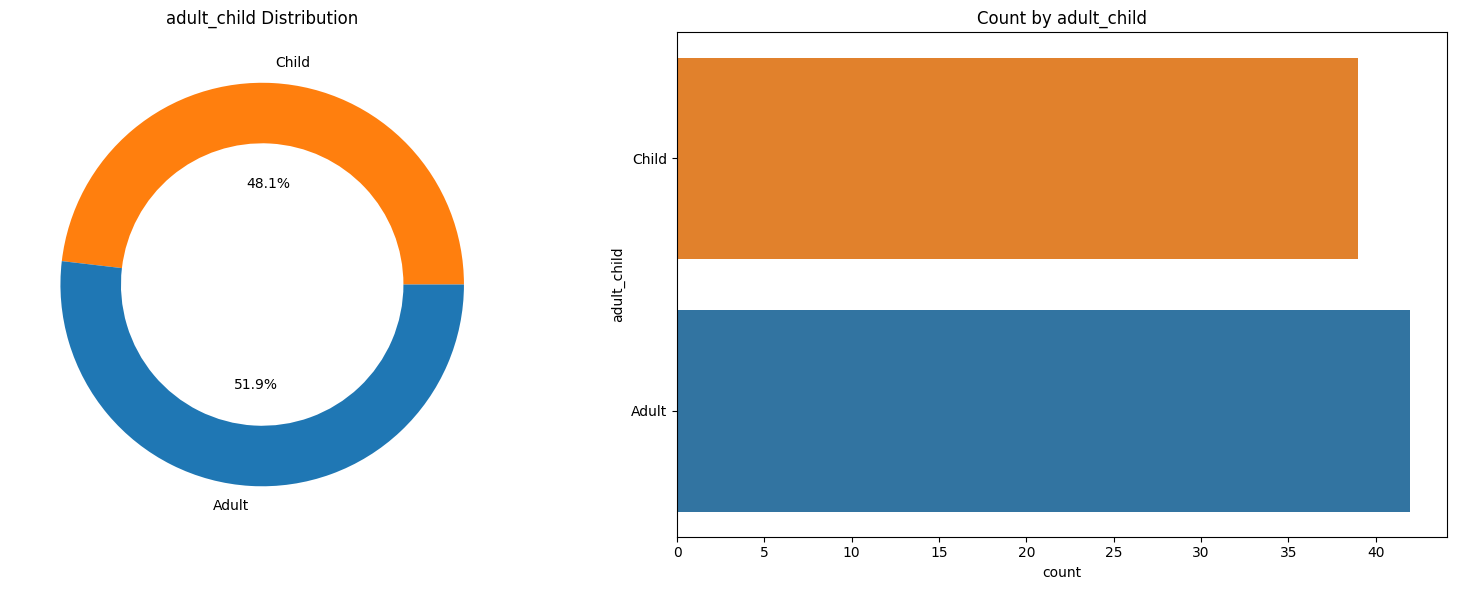

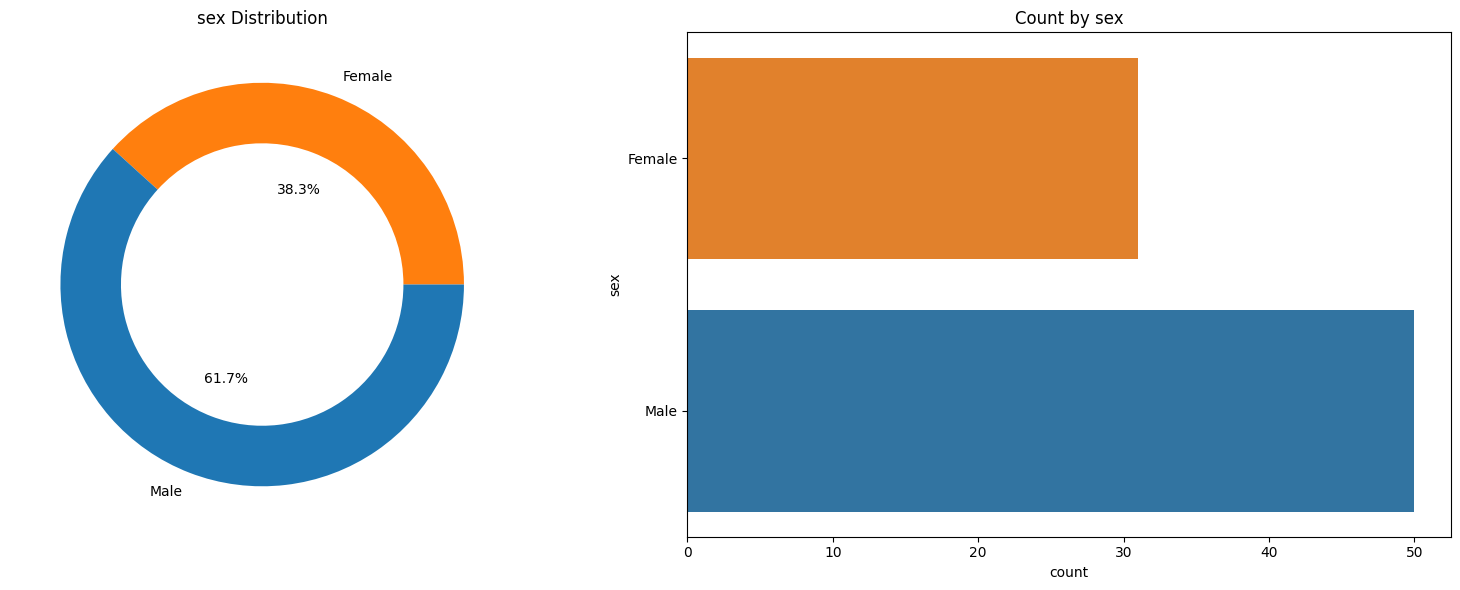

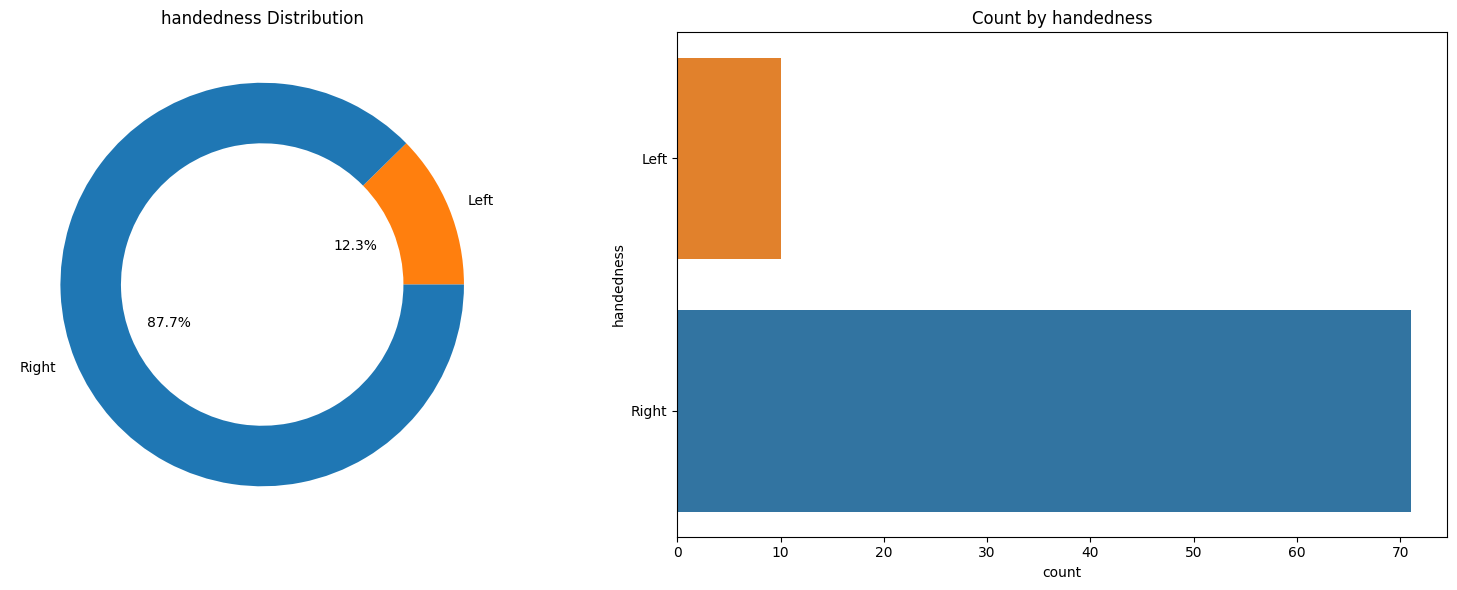

In [10]:
# categorical variables to analyze with respective value mappings
categorical_variables = ["adult_child", "sex", "handedness"]
value_mappings = {"adult_child": {0: "Child", 1: "Adult"}, "sex": {0: "Female", 1: "Male"}, "handedness": {0: "Left", 1: "Right"}}

# define plotting function for categorical variables
def plot_categorical(variable, data, value_mapping=None):

    colors = {0: '#ff7f0e', 1: '#1f77b4'}
    plt.figure(figsize=(16, 6))
    
    # get value counts and sort by index
    value_counts = data[variable].value_counts().sort_index()
    
    # create labels using the mapping if available, otherwise use original values
    labels = [value_mapping.get(i, str(i)) for i in value_counts.index]
    
    # pie chart
    plt.subplot(1, 2, 1)
    plt.pie(value_counts, autopct='%1.1f%%', colors=[colors.get(i, '#2ca02c') for i in value_counts.index], wedgeprops=dict(width=0.3), labels=labels, pctdistance=0.5)
    plt.title(f"{variable} Distribution")
    
    # countplot
    plt.subplot(1, 2, 2)
    ax = sns.countplot(data=data, y=variable, order=value_counts.index, palette=[colors.get(i, '#2ca02c') for i in value_counts.index])
    
    # update y-tick labels
    ax.set_yticklabels(labels)
    plt.title(f"Count by {variable}")
    plt.tight_layout()
    plt.show()

# generate plots for each categorical variable
for var in categorical_variables:
    if var in train_demo.columns:
        plot_categorical(variable=var, data=train_demo, value_mapping=value_mappings.get(var))

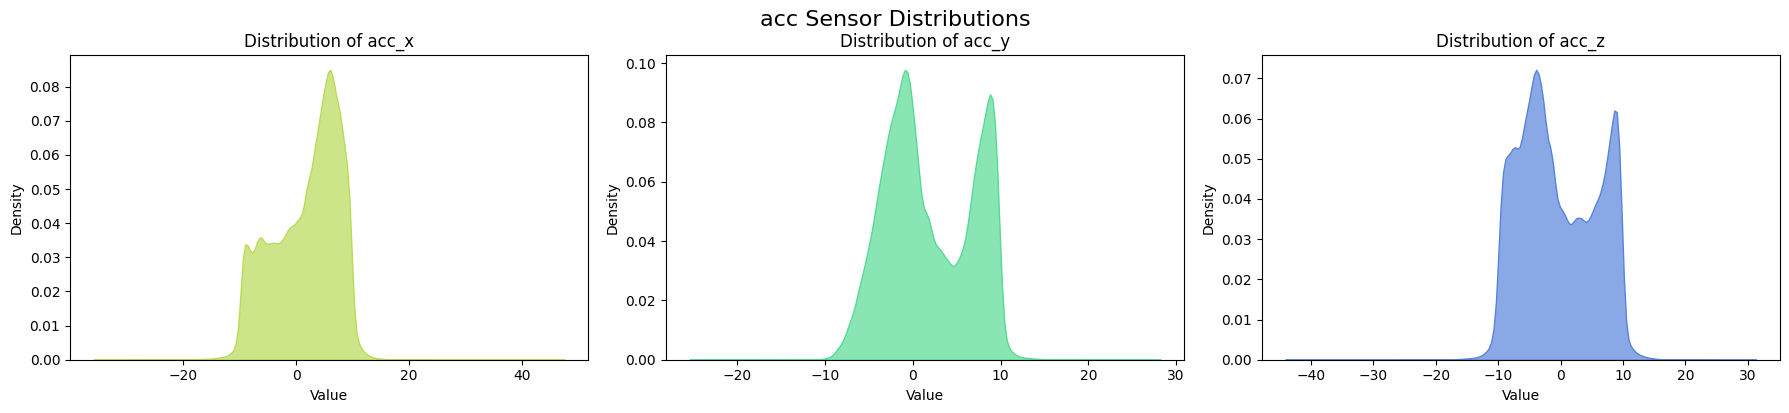


Summary Statistics for acc sensors:


,count,mean,std,min,25%,50%,75%,max
acc_x,562688.0,1.722759,5.752787,-34.585938,-2.765625,3.074219,6.371094,46.328125
acc_y,562688.0,1.874918,4.978619,-24.402344,-2.074219,0.753906,6.906250,27.183594
acc_z,562688.0,-0.454414,6.096569,-42.855469,-5.421875,-1.562500,5.179688,30.078125


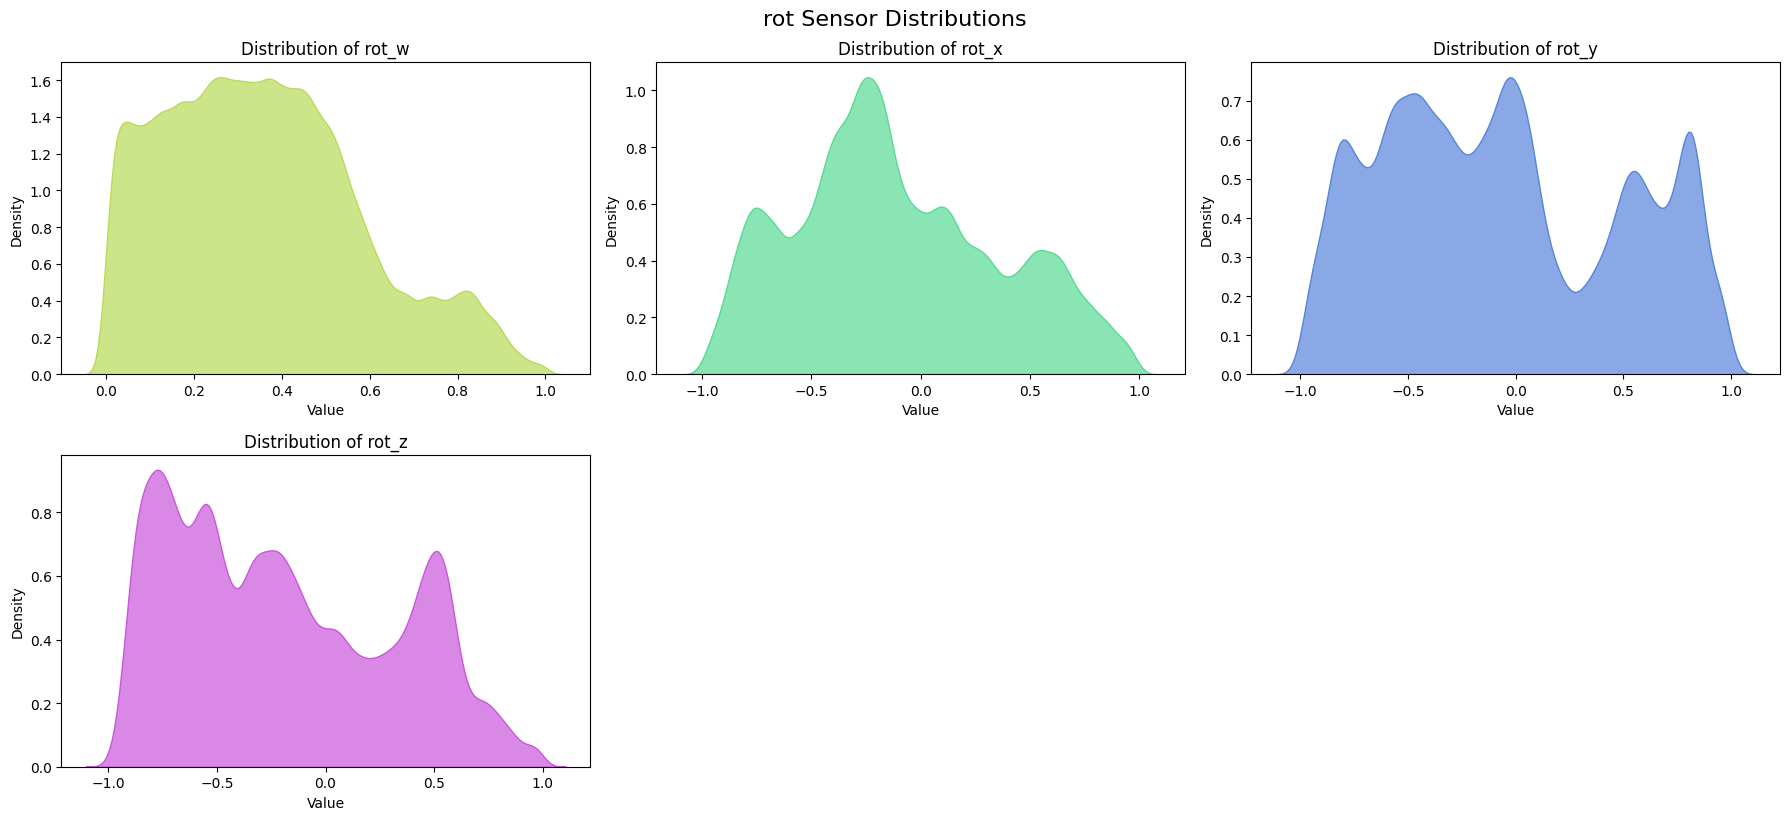


Summary Statistics for rot sensors:


,count,mean,std,min,25%,50%,75%,max
rot_w,558996.0,0.357413,0.224144,0.000000,0.178406,0.337769,0.499939,0.999390
rot_x,558996.0,-0.113529,0.465845,-0.999146,-0.447388,-0.181763,0.214539,0.999817
rot_y,558996.0,-0.066103,0.543077,-0.999695,-0.514893,-0.122070,0.435547,0.999451
rot_z,558996.0,-0.194103,0.505111,-0.998169,-0.635437,-0.272949,0.245178,0.999878


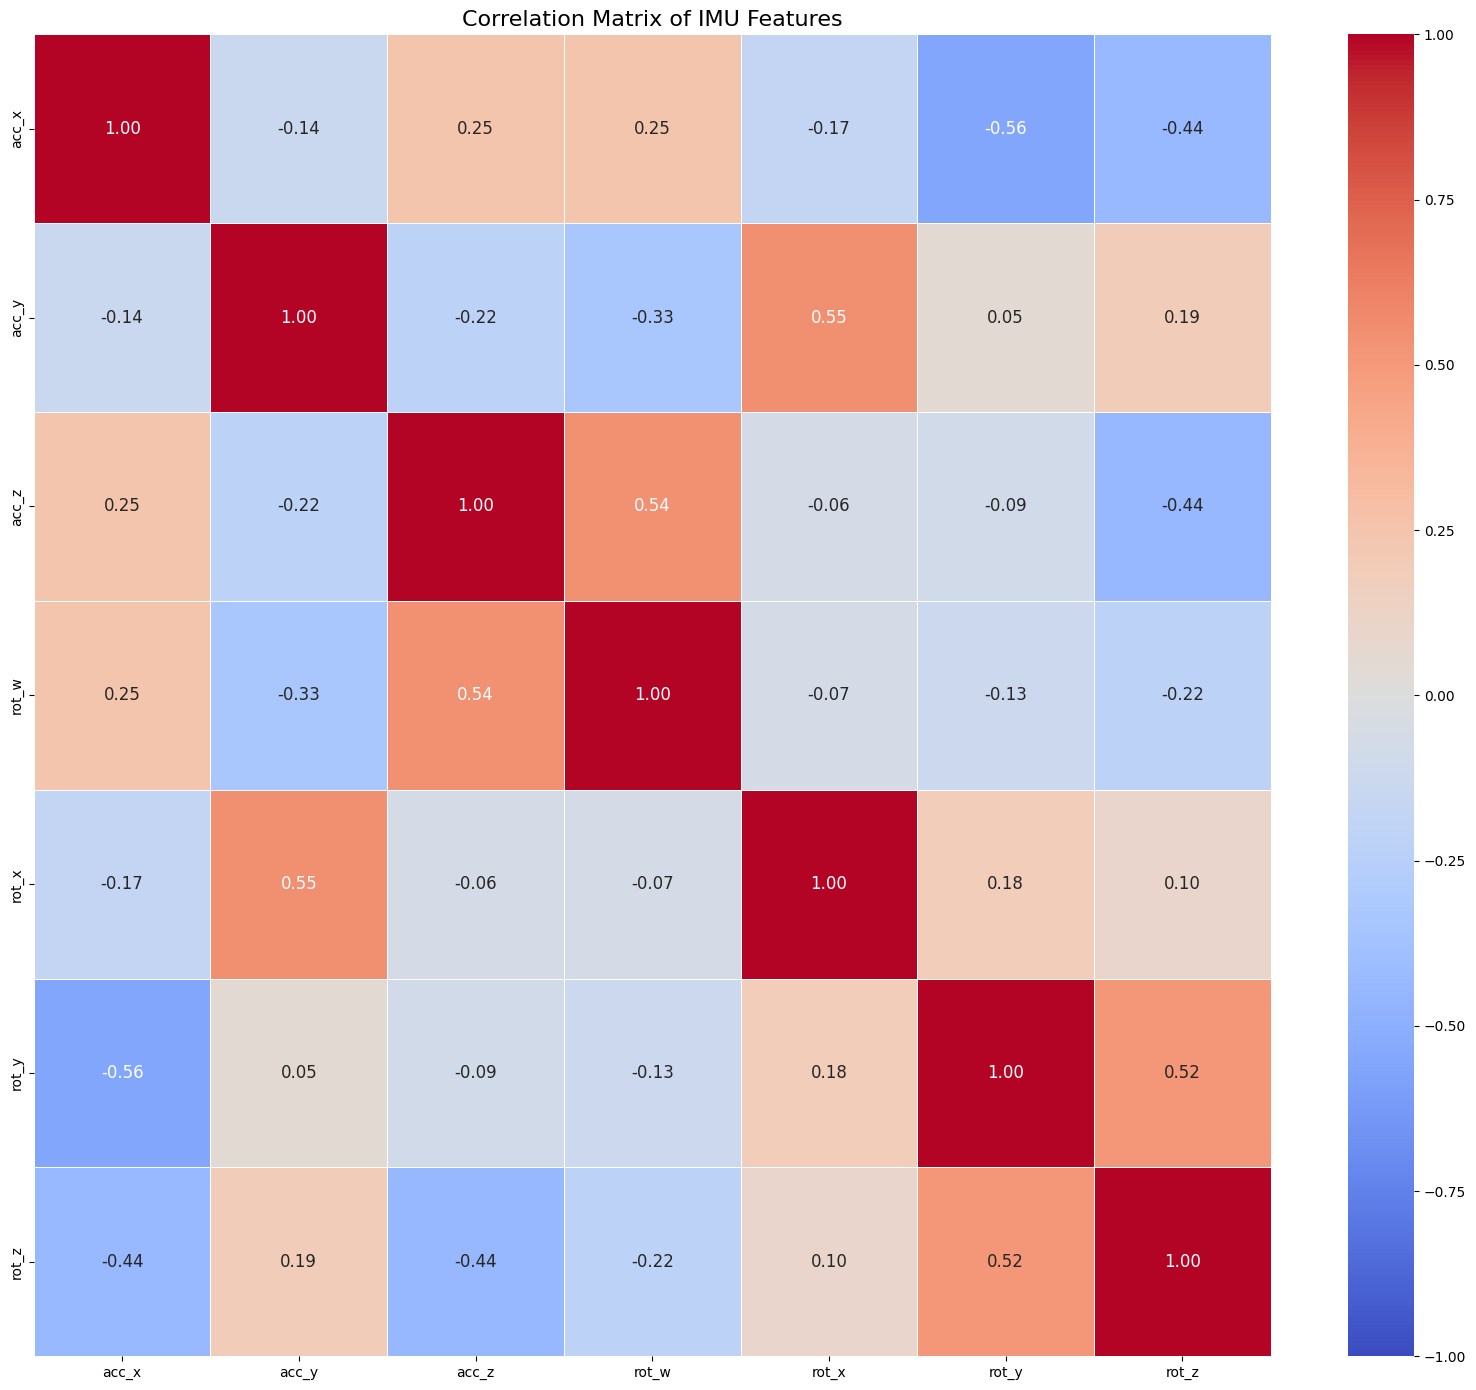

In [11]:
custom_palette = sns.color_palette("hls", n_colors=5)

# plotting density curve function
def plot_sensor_distributions(df, sensor_type, cols_per_row=3):
    sensor_cols = [col for col in df.columns if sensor_type in col]
    if not sensor_cols:
        print(f"No columns found for {sensor_type}.")
        return
    n_cols = len(sensor_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    plt.figure(figsize=(18, 4 * n_rows))
    for i, col in enumerate(sensor_cols, 1):
        plt.subplot(n_rows, cols_per_row, i)
        sns.kdeplot(df[col].dropna(), fill=True, alpha=0.7, 
                    color=custom_palette[i % len(custom_palette)])
        plt.title(f'Distribution of {col}', fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Density')
    plt.tight_layout()
    plt.suptitle(f'{sensor_type} Sensor Distributions', y=1.02, fontsize=16)
    plt.show()
    print(f"\nSummary Statistics for {sensor_type} sensors:")
    display(df[sensor_cols].describe().T)
    print()
    print()

# visualize IMU distributions
plot_sensor_distributions(train, 'acc')
plot_sensor_distributions(train, 'rot')

# generate correlation heatmap
sensor_cols = [col for col in train.columns if 'acc' in col or 'rot' in col]
if sensor_cols:
    plt.figure(figsize=(16, 14))
    corr_matrix = train[sensor_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"fontsize": 12})
    plt.title('Correlation Matrix of IMU Features', fontsize=16)
    plt.tight_layout()
    plt.show()

Talk about the intuitive relationship between orientation and acceleration (look at the OTHER diagonal)

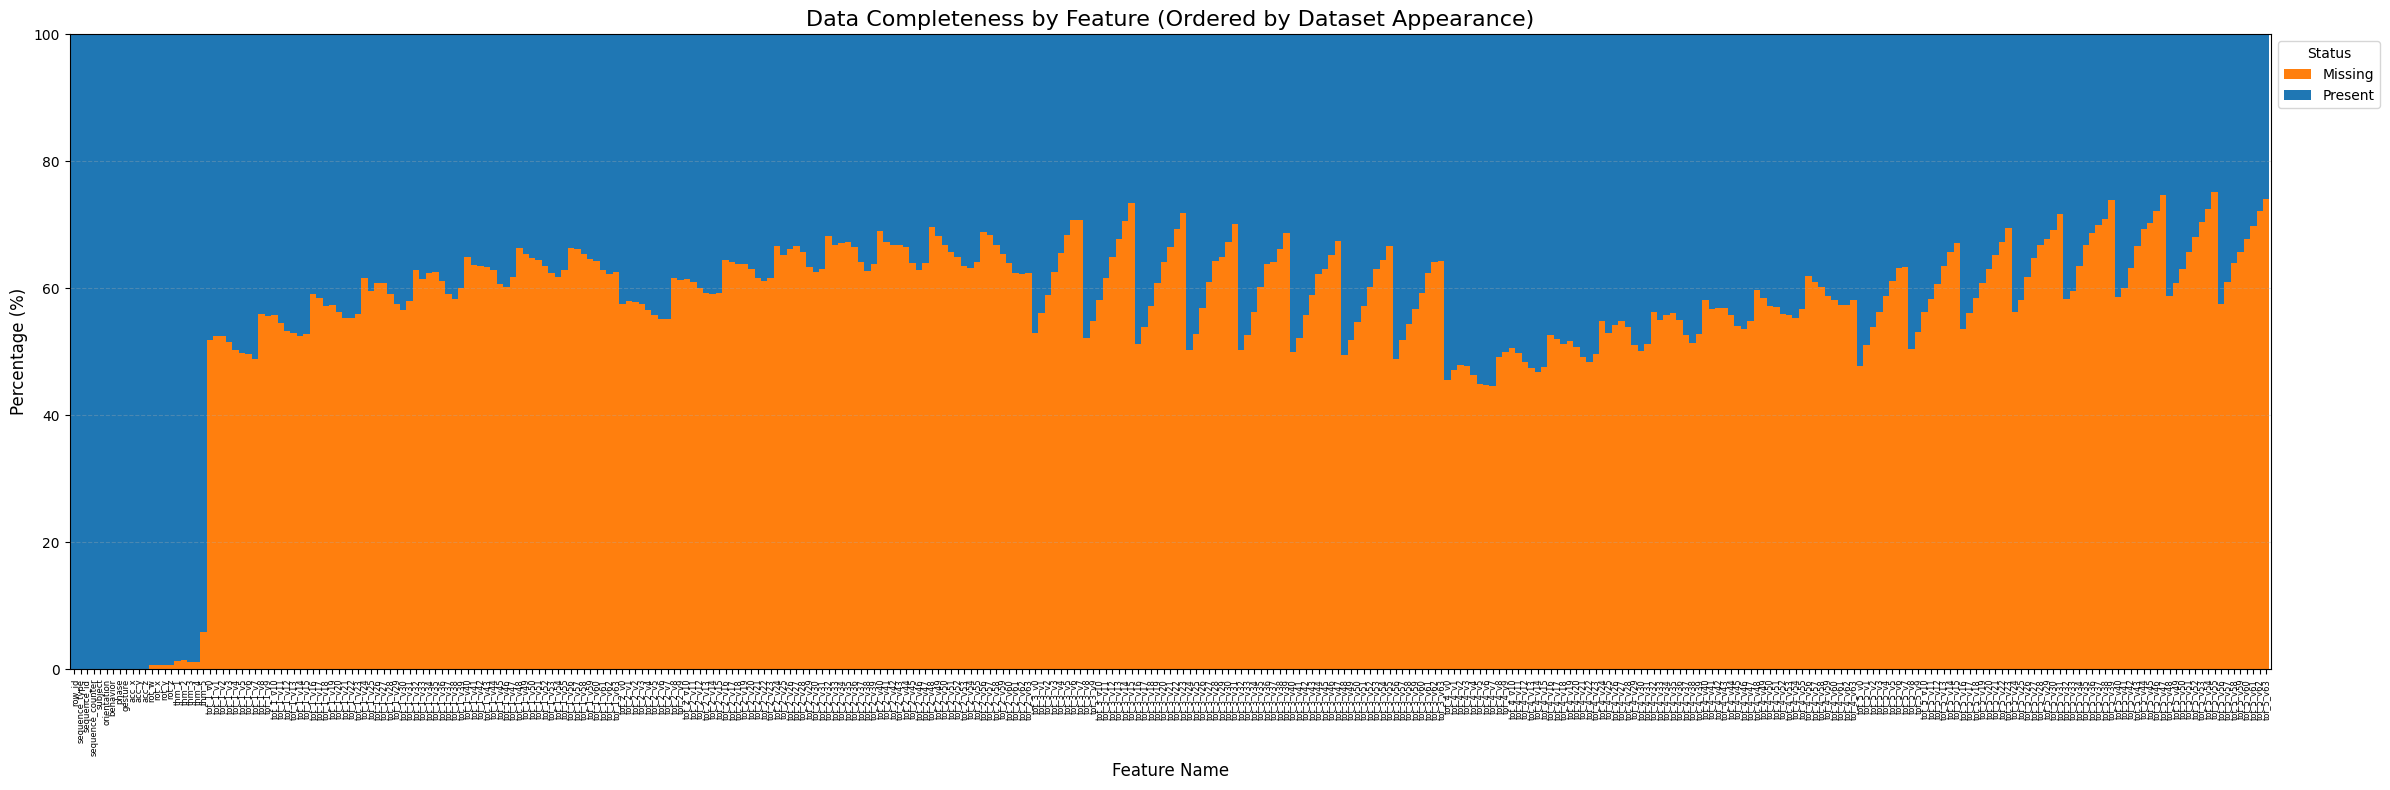

In [12]:
# replace -1 and 0 with NaN in Time-of-Flight columns
tof_cols = [c for c in train.columns if c.startswith('tof_')]
train[tof_cols] = train[tof_cols].replace([-1, 0], np.nan)
test[tof_cols] = test[tof_cols].replace([-1, 0], np.nan)

# calculate missingness
missing_pct = train.isnull().mean() * 100
completeness_df = pd.DataFrame({'Missing': missing_pct,'Present': 100 - missing_pct})

# generate stacked bar chart
plt.figure(figsize=(24, 8)) 
ax = completeness_df.plot(kind='bar', stacked=True, color=['#ff7f0e', '#1f77b4'], width=1.0, ax=plt.gca())
plt.title('Data Completeness by Feature (Ordered by Dataset Appearance)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Feature Name', fontsize=12)
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Status')
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Give an intuitive explanation for why it makes sense to replace missing ToF data with a large integer like 400.

In [13]:
from sklearn.impute import SimpleImputer

# impute missing rot values with 0
rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
train[rots] = train[rots].fillna(0)

# fill missing temperature data with average by column
thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
imputer = SimpleImputer(strategy='constant', fill_value=0)
train[thms] = imputer.fit_transform(train[thms])

# fill all NaNs in time-of-flight (ToF) columns with 400
tof_train = train.loc[:, "tof_1_v0" : "tof_5_v63"].columns
train[tof_train] = train[tof_train].fillna(400)
tof_test = test.loc[:, "tof_1_v0" : "tof_5_v63"].columns
test[tof_test] = test[tof_test].fillna(400)

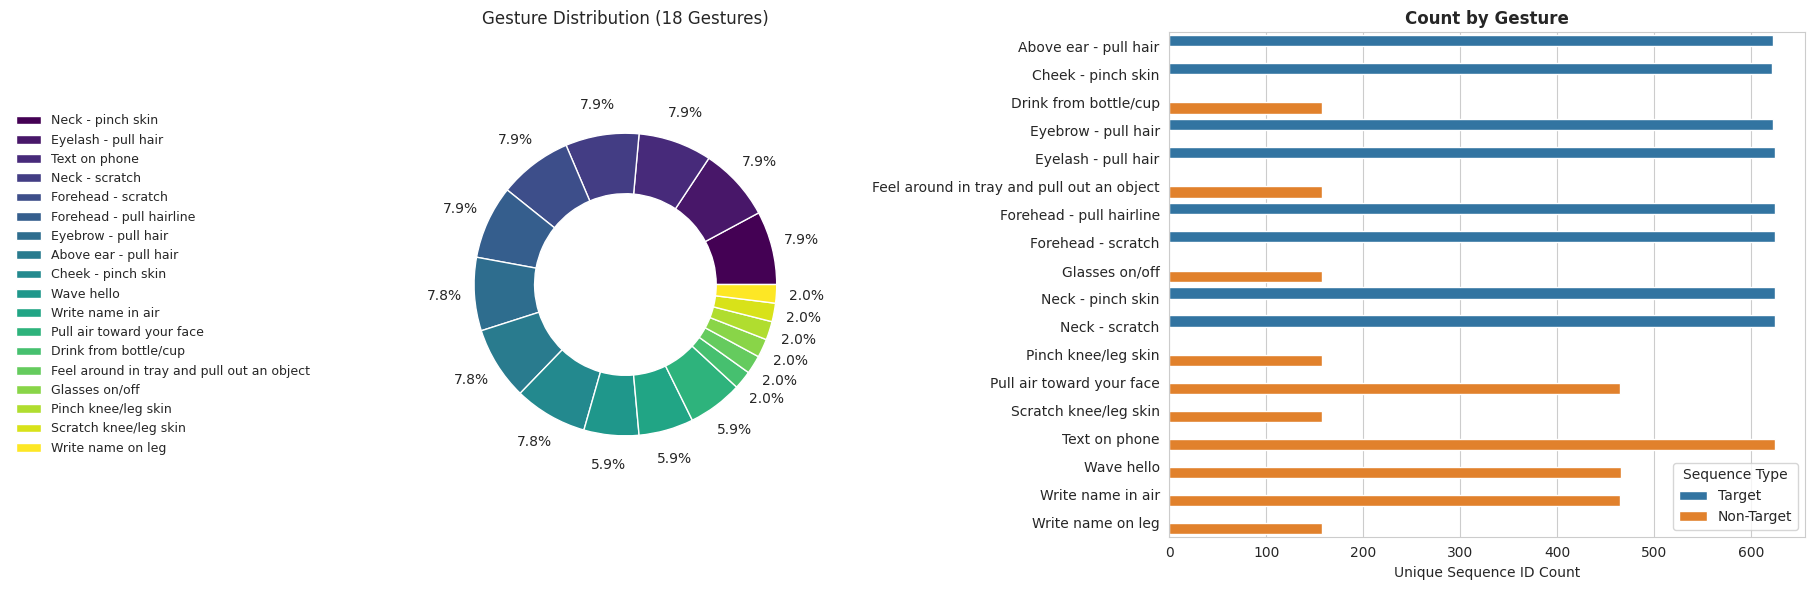

In [14]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# gesture distribution donut chart
value_counts = train.groupby('gesture')['sequence_id'].nunique().sort_values(ascending=False)
num_gestures = len(value_counts)
palette = [to_hex(viridis(i / (num_gestures - 1))) for i in range(num_gestures)]
ax1.pie(value_counts, autopct='%1.1f%%', colors=palette, radius=0.75, wedgeprops={'width': 0.3}, pctdistance=1.2)
ax1.legend(value_counts.index, bbox_to_anchor=(-0.1, 0.5), loc='center right', prop={'size': 9}, frameon=False, borderpad=0.5, labelspacing=0.5)
ax1.set_title(f"Gesture Distribution ({num_gestures} Gestures)")
group_df = train.groupby(['gesture', 'sequence_type'])['sequence_id'].nunique().reset_index()

# generate bar count plot
sns.barplot(data=group_df, y='gesture', x='sequence_id', hue='sequence_type', palette=['#1f77b4', '#ff7f0e'], ax=ax2)
ax2.set(xlabel='Unique Sequence ID Count', ylabel='')
ax2.legend(title='Sequence Type')
ax2.set_title("Count by Gesture", fontweight='bold')

plt.tight_layout()
plt.show()

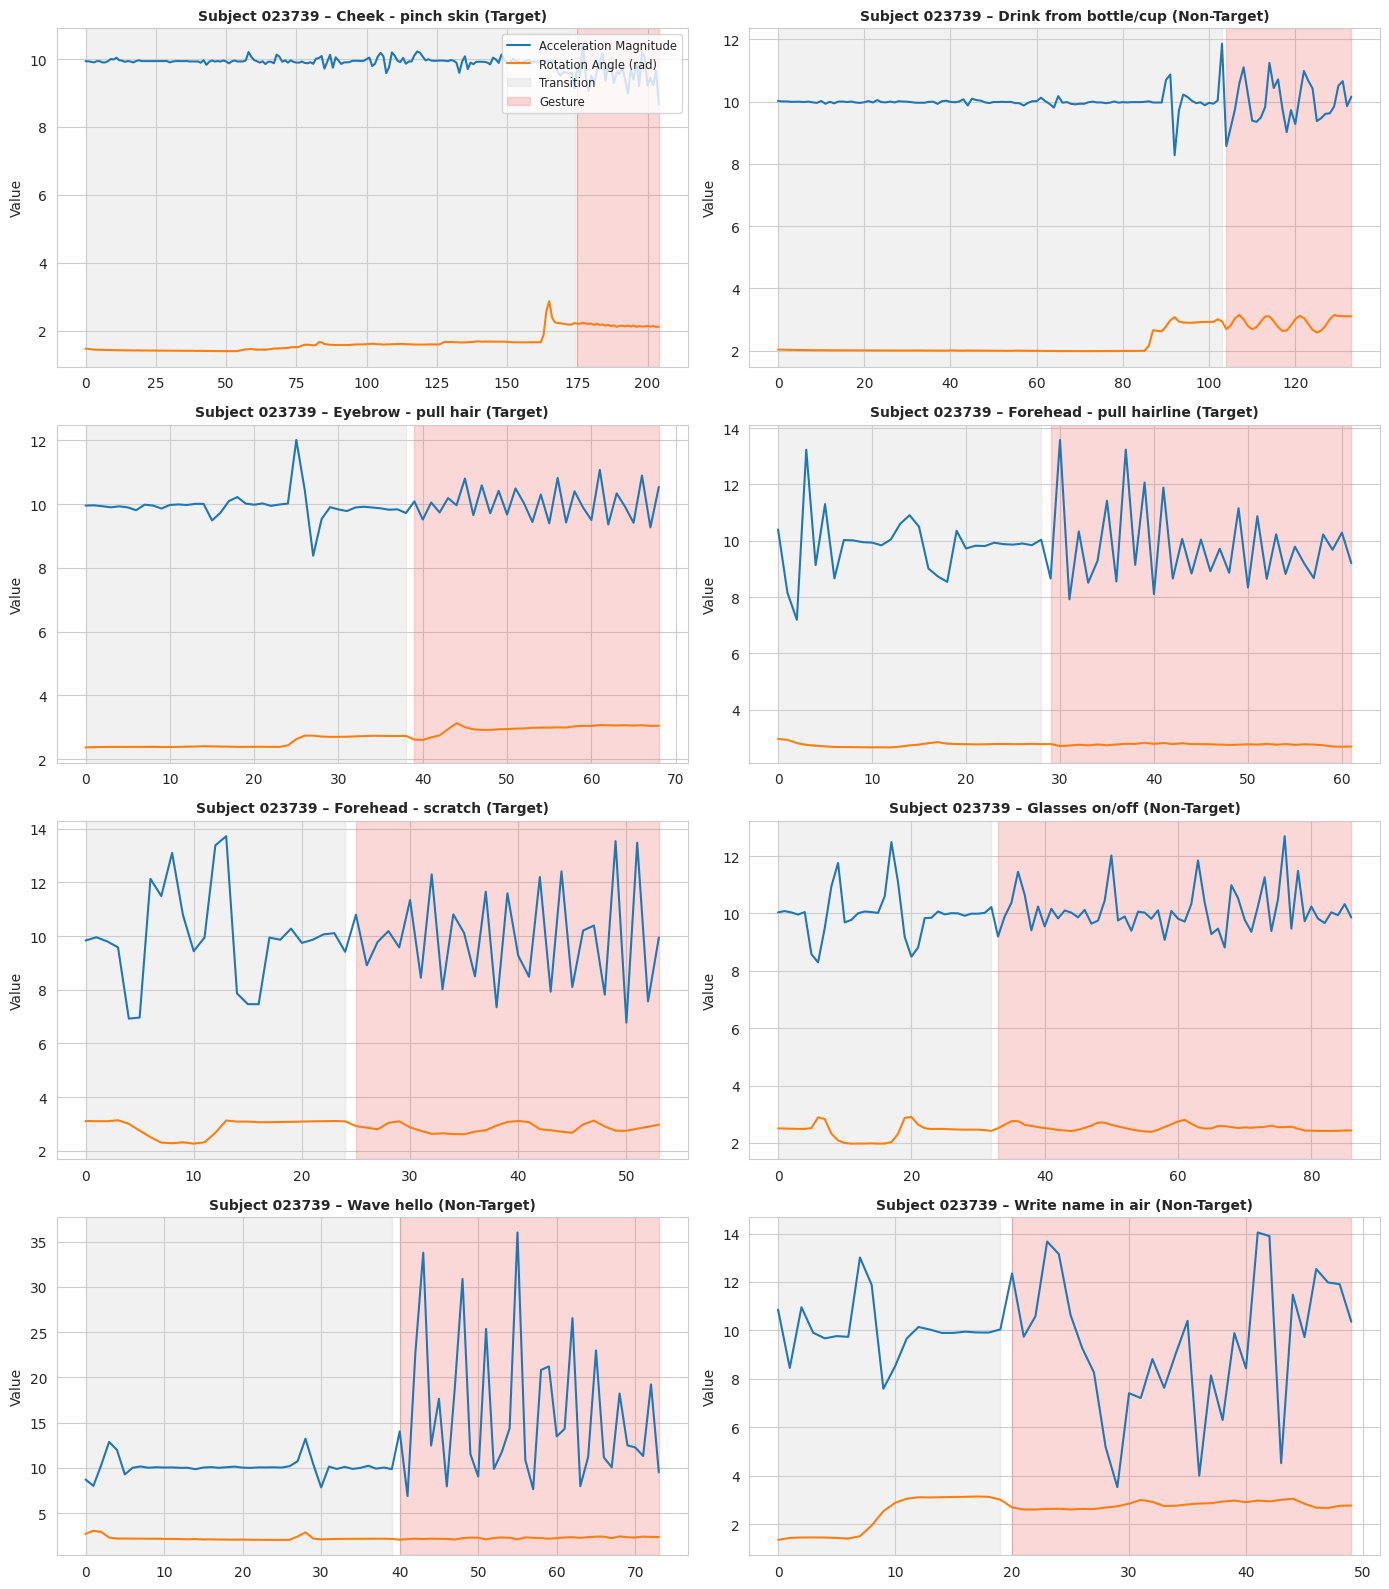

In [15]:
# GESTURE SAMPLE ANALYSIS FROM SUBJECT 023739

# compute features
subj_023739 = train[train['subject'] == 'SUBJ_023739'].copy()
subj_023739['acc_mag'] = np.sqrt(subj_023739[['acc_x', 'acc_y', 'acc_z']].pow(2).sum(axis=1))
subj_023739['rot_angle'] = 2 * np.arccos(subj_023739['rot_w'].clip(-1, 1))

# get one sequence per gesture
selected_gestures = ["Cheek - pinch skin", "Drink from bottle/cup", "Eyebrow - pull hair", "Forehead - pull hairline", "Forehead - scratch", "Glasses on/off", "Wave hello", "Write name in air"]
seq_ids = subj_023739[subj_023739['gesture'].isin(selected_gestures)].groupby('gesture')['sequence_id'].first().values

# setup figure
n = len(seq_ids)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), squeeze=False)
axes = axes.flatten()

# plot data
for i, seq in enumerate(seq_ids):
    ax = axes[i]
    df = subj_023739[subj_023739['sequence_id'] == seq].sort_values('sequence_counter')
    times = df['sequence_counter']
    ax.plot(times, df['acc_mag'], label='Acceleration Magnitude', color='tab:blue')
    ax.plot(times, df['rot_angle'], label='Rotation Angle (rad)', color='tab:orange')
    
    # add phase shading
    for phase, color in [('Transition', 'lightgray'), ('Gesture', 'lightcoral')]:
        mask = df['phase'] == phase
        if not mask.any(): continue
        idxs = np.where(mask)[0]
        for start, end in zip(np.concatenate(([0], np.where(np.diff(idxs) > 1)[0] + 1)), np.concatenate((np.where(np.diff(idxs) > 1)[0], [len(idxs)-1]))):
            t0, t1 = df.iloc[idxs[start]]['sequence_counter'], df.iloc[idxs[end]]['sequence_counter']
            ax.axvspan(t0, t1, color=color, alpha=0.3, label=phase if phase not in ax.get_legend_handles_labels()[1] else None)
    
    # format subplot
    ax.set_title(f"Subject 023739 – {df['gesture'].iloc[0]} ({df['sequence_type'].iloc[0]})", fontsize=10, fontweight='bold')
    ax.set(xlabel="", ylabel="Value")
    ax.legend(loc='upper right', fontsize='small').set_visible(i == 0)  # Only show legend for first plot
    ax.grid(True)

# clean up and show
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

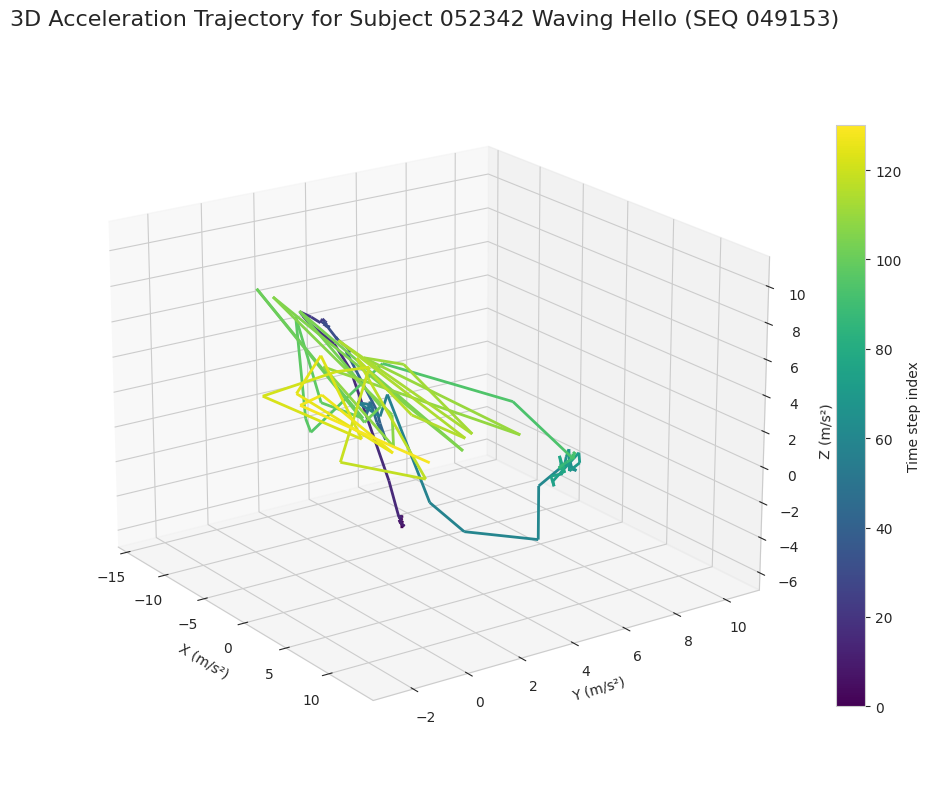

In [16]:
# 3D RENDERING OF ACCELERATION TRAJECTORY FOR SUBJECT 052342 WAVING "HELLO"

seq_049153 = train[train['sequence_id'] == 'SEQ_049153'].copy()
x_data = seq_049153['acc_x'].values
y_data = seq_049153['acc_y'].values
z_data = seq_049153['acc_z'].values

# plot 3D trajectory
def plot_3d_trajectory(x, y, z, title="3D Trajectory"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    time_steps = np.arange(len(x))
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = plt.get_cmap('viridis')
    lc = Line3DCollection(segments, cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    lc.set_array(time_steps)
    lc.set_linewidth(2)
    ax.add_collection3d(lc)

    # add a color bar
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.set_label('Time step index')

    # customize the plot
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X (m/s²)')
    ax.set_ylabel('Y (m/s²)')
    ax.set_zlabel('Z (m/s²)')

    # final details
    buffer = 1.5
    ax.set_xlim(x.min() - buffer, x.max() + buffer)
    ax.set_ylim(y.min() - buffer, y.max() + buffer)
    ax.set_zlim(z.min() - buffer, z.max() + buffer)
    ax.view_init(elev=20., azim=-35)
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_3d_trajectory(x_data, y_data, z_data, title="3D Acceleration Trajectory for Subject 052342 Waving Hello (SEQ 049153)")

In [17]:
# filter out short gesture sequences (bad data)
print("Before filtering:", train.shape)
gesture_counts = ((train['phase'] == 'Gesture').groupby(train['sequence_id']).transform('sum'))
train = train[gesture_counts >= 15].reset_index(drop=True)
print("After filtering:",train.shape)

Before filtering: (562688, 341)
After filtering: (560044, 341)


### Taking account for the Lefties

Identify the lefties in the train set and apply a coordinate system transformation so they match the right hand. This is supposedly only necessary for accelaration and orientation, not time-of-flight or thermophile. (I pinned a gemini chat for how to program this)

Left handed subjects: 002923, 013623, 019756, 028998, 032233, 032585, 039234, 041243, 055211, 061552

In [18]:
# STANDARDIZE LEFT HAND TO MATCH RIGHT HAND

lefties = ["SUBJ_002923", "SUBJ_013623", "SUBJ_019756", "SUBJ_028998", "SUBJ_032233", "SUBJ_032585", "SUBJ_039234", "SUBJ_041243", "SUBJ_055211", "SUBJ_061552"]
lefty_mask = train.subject.isin(lefties)

# transform acceleration data
train.loc[lefty_mask, 'acc_y'] = -train.loc[lefty_mask, 'acc_y']
train.loc[lefty_mask, 'acc_z'] = -train.loc[lefty_mask, 'acc_z']

# transform orientation data
q_original = train.loc[lefty_mask, ['rot_w', 'rot_x', 'rot_y', 'rot_z']].copy()
train.loc[lefty_mask, 'rot_w'] = -q_original['rot_x']
train.loc[lefty_mask, 'rot_x'] =  q_original['rot_w']
train.loc[lefty_mask, 'rot_y'] = -q_original['rot_z']
train.loc[lefty_mask, 'rot_z'] =  q_original['rot_y']

### Converting from a Local to a Global Frame

Explain what linear interpolation is and why it is so important.

In [19]:
# linear interpolation for missing acceleration data
acc_cols = ["acc_x", "acc_y", "acc_z"]
train[acc_cols] = train[acc_cols].interpolate(method='linear', limit_direction='both')

In [20]:
import random

# create validation set
sequences = train['sequence_id'].unique().tolist()
val_sequences = random.sample(sequences, int(len(sequences) * 0.2))
validation = train[train['sequence_id'].isin(val_sequences)].copy()
train = train[~train['sequence_id'].isin(val_sequences)].reset_index(drop=True)

In [21]:
# define irrelevant columns
columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']

# remove irrelevant columns from train, test and validation sets (leaving backup validation for evaluation)
train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
validation = validation.drop(columns=[col for col in columns_to_drop if col in validation.columns])
test = test.drop(columns=[col for col in columns_to_drop if col in test.columns])

# create set list
sets = [train, test, validation]

## Feature Engineering

Features to create:
- lin_acc_x
- lin_acc_y
- lin_acc_z
- acc_mag
- lin_acc_mag
- acc_mag_jerk
- lin_acc_mag_jerk
- rot_angle
- angular_distance
- rot_angle_vel
- angular_vel_x
- angular_vel_y
- angular_vel_z

Jerk: derivative of acceleration

In [22]:
# de-fragment train/test/val sets
train = train.copy()
test = test.copy()
validation = validation.copy()

In [23]:
# consolidated calculation of features
def calculate_sequence_features(group):
    acc = group[['acc_x', 'acc_y', 'acc_z']].values
    rot = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    time_step = 0.1
    gravity_world = np.array([0, 0, 9.81])
    new_feats = {}

    # -> SIMPLE FEATURES
    # linear acceleration (acceleration w/ gravity removed)
    norms = np.linalg.norm(rot, axis=1)
    valid_mask = norms > 1e-6
    lin_acc = acc.copy()
    
    if np.any(valid_mask):
        q_norm = rot[valid_mask] / norms[valid_mask][:, None]
        r = R.from_quat(q_norm)
        g_sensor = r.apply(gravity_world, inverse=False)
        lin_acc[valid_mask] = acc[valid_mask] - g_sensor

    new_feats['lin_acc_x'] = lin_acc[:, 0]
    new_feats['lin_acc_y'] = lin_acc[:, 1]
    new_feats['lin_acc_z'] = lin_acc[:, 2]

    # magnitudes of acceleration
    acc_mag = np.linalg.norm(acc, axis=1)
    lin_acc_mag = np.linalg.norm(lin_acc, axis=1)
    new_feats['acc_mag'] = acc_mag
    new_feats['lin_acc_mag'] = lin_acc_mag

    # jerk features (derivatives [gradient] of magnitudes)
    new_feats['acc_mag_jerk'] = np.gradient(acc_mag, time_step)
    new_feats['lin_acc_mag_jerk'] = np.gradient(lin_acc_mag, time_step)

    # rotation angle
    rot_w_clipped = np.clip(group['rot_w'].values, -1.0, 1.0)
    new_feats['rot_angle'] = 2 * np.arccos(rot_w_clipped)

    # -> COMPLEX FEATURES
    q_curr = rot
    q_prev = np.roll(rot, 1, axis=0)
    q_prev[0] = [0, 0, 0, 1]
    q_prev_conj = q_prev.copy()
    q_prev_conj[:, :3] = -q_prev_conj[:, :3]
    w1, x1, y1, z1 = q_curr[:, 3], q_curr[:, 0], q_curr[:, 1], q_curr[:, 2]
    w2, x2, y2, z2 = q_prev_conj[:, 3], q_prev_conj[:, 0], q_prev_conj[:, 1], q_prev_conj[:, 2]
    delta_w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    
    # angular Distance
    delta_w_clip = np.clip(delta_w, -1.0, 1.0)
    ang_dist = 2 * np.arccos(delta_w_clip)
    ang_dist[0] = 0
    new_feats['angular_distance'] = ang_dist
    
    # rotation angle velocity
    new_feats['rot_angle_vel'] = ang_dist * 0.1

    # angular velocity
    delta_x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    delta_y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    delta_z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    
    # normalize delta
    delta_vec = np.stack([delta_x, delta_y, delta_z], axis=1)
    dnorm = np.linalg.norm(delta_vec, axis=1)
    angle_full = 2.0 * np.arctan2(dnorm, delta_w)
    with np.errstate(divide='ignore', invalid='ignore'):
        scale = angle_full / (time_step * dnorm)
        scale[dnorm < 1e-12] = 2.0 / time_step
    omega = delta_vec * scale[:, None]
    omega[0] = [0, 0, 0]
    new_feats['angular_vel_x'] = omega[:, 0]
    new_feats['angular_vel_y'] = omega[:, 1]
    new_feats['angular_vel_z'] = omega[:, 2]
    return pd.DataFrame(new_feats, index=group.index)

# consolidate and add new features to train/test/val datasets
names = ['train', 'test', 'validation']
NEW_IMU_FEATURES = ['lin_acc_x', 'lin_acc_y', 'lin_acc_z','acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']

for i, dataset in enumerate(sets):
    dataset = dataset.copy()
    results = [calculate_sequence_features(group) for _, group in dataset.groupby('sequence_id')]
    all_new_features = pd.concat(results)
    dataset = pd.concat([dataset, all_new_features], axis=1)
    id_cols = ['sequence_id']
    
    if 'gesture' in dataset.columns:
        id_cols.append('gesture')
    original_cols = [col for col in dataset.columns if col not in id_cols and col not in NEW_IMU_FEATURES]
    final_order = id_cols + NEW_IMU_FEATURES + original_cols
    dataset = dataset[final_order]
    
    if names[i] == 'train':
        train = dataset
    elif names[i] == 'test':
        test = dataset
    elif names[i] == 'validation':
        validation = dataset

Also explain what "rotation angle" is. Talk about the relationship between rotation angle, rotation angle velocity, and angular distance.

***


### FEATURE SCALING
Feature scaling is the process of transforming the numerical features of your data into a common scale. The idea is to strip away the original units and magintude of a feature, and instead represent its values based on their position relative to the other values in that same feature. You could accomplish this using various statistical methods, such as min-max scaling, z-score normalization.

Use Z-score normalization (StandardScaler)

In [24]:
from sklearn.preprocessing import RobustScaler

# fit standard scaler
scaler = RobustScaler() 

# scale train
train_cols_to_exclude = ['sequence_id', 'gesture']
train_cols_to_scale = train.drop(columns=train_cols_to_exclude).columns
scaler.fit(train[train_cols_to_scale])
X_train = scaler.transform(train[train_cols_to_scale])

# scale test
test_cols_to_exclude = ['sequence_id']
test_cols_to_scale = test.drop(columns=test_cols_to_exclude).columns
X_test = scaler.transform(test[test_cols_to_scale])

# scale validation
validation_cols_to_exclude = ['sequence_id', 'gesture']
validation_cols_to_scale = validation.drop(columns=validation_cols_to_exclude).columns
X_val = scaler.transform(validation[validation_cols_to_scale])

In [25]:
# cleaning up variable names (for consistency)
train_IMU_THM_TOF_prescaled = train
train_IMU_THM_TOF_scaled = X_train
test_IMU_THM_TOF_prescaled = test
test_IMU_THM_TOF_scaled = X_test
val_IMU_THM_TOF_prescaled = validation
val_IMU_THM_TOF_scaled = X_val

In [26]:
# garbage collection (for memory)
import gc

del train
del train_placeholder
del X_train
del test
del X_test
del validation
del X_val

***

## Sequencing and Padding

In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import logging
tf.get_logger().setLevel('ERROR')


E0000 00:00:1764041741.743528      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764041741.805384      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

*As of November 2025, there is a bug when initially importing TensorFlow into web-based environments like Kaggle and Google Colab where it attempts to call a method "GetPrototype" that no longer exists. It has no effect on the library's functionality or any code, but it creates a very ugly warning message.*

In [28]:
train_IMU_THM_TOF_prescaled = train_IMU_THM_TOF_prescaled.reset_index(drop=True)
test_IMU_THM_TOF_prescaled = test_IMU_THM_TOF_prescaled.reset_index(drop=True)
val_IMU_THM_TOF_prescaled = val_IMU_THM_TOF_prescaled.reset_index(drop=True)

# sequence train data
grouped_train_ALL = train_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_train_ALL = []
labels_train_ALL = []
for sequence_id, group in grouped_train_ALL:
    indices_train = group.index.to_list()
    current_sequence_data = train_IMU_THM_TOF_scaled[indices_train]
    sequences_train_ALL.append(current_sequence_data)
    
    label_train_ALL = group['gesture'].iloc[0]
    labels_train_ALL.append(label_train_ALL)

# sequence test data
grouped_test_ALL = test_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_test_ALL = []
for sequence_id, group in grouped_test_ALL:
    indices_test = group.index.to_list()
    current_sequence_data = test_IMU_THM_TOF_scaled[indices_test]
    sequences_test_ALL.append(current_sequence_data)

# sequence val data
grouped_val_ALL = val_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_val_ALL = []
labels_val_ALL = []
for sequence_id, group in grouped_val_ALL:
    indices_val = group.index.to_list()
    current_sequence_data = val_IMU_THM_TOF_scaled[indices_val]
    sequences_val_ALL.append(current_sequence_data)
    
    label_val_ALL = group['gesture'].iloc[0]
    labels_val_ALL.append(label_val_ALL)

In [29]:
# pad data
def pad_data(sequences, max_length=None):
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', maxlen=700)
    return padded_sequences

train_padded_ALL = pad_data(sequences_train_ALL)
test_padded_ALL = pad_data(sequences_test_ALL)
val_padded_ALL = pad_data(sequences_val_ALL)

y_train_ALL = np.array(labels_train_ALL)
y_val_ALL = np.array(labels_val_ALL)

print("Shape of the final padded data:", train_padded_ALL.shape) 
print("Shape of the final padded data:", test_padded_ALL.shape) 
print("Shape of the final padded data:", val_padded_ALL.shape) 

Shape of the final padded data: (6336, 700, 345)
Shape of the final padded data: (2, 700, 345)
Shape of the final padded data: (1584, 700, 345)


In [30]:
# garbage collection (for memory)
del sequences_train_ALL
del sequences_test_ALL
del sequences_val_ALL
del labels_train_ALL
del labels_val_ALL

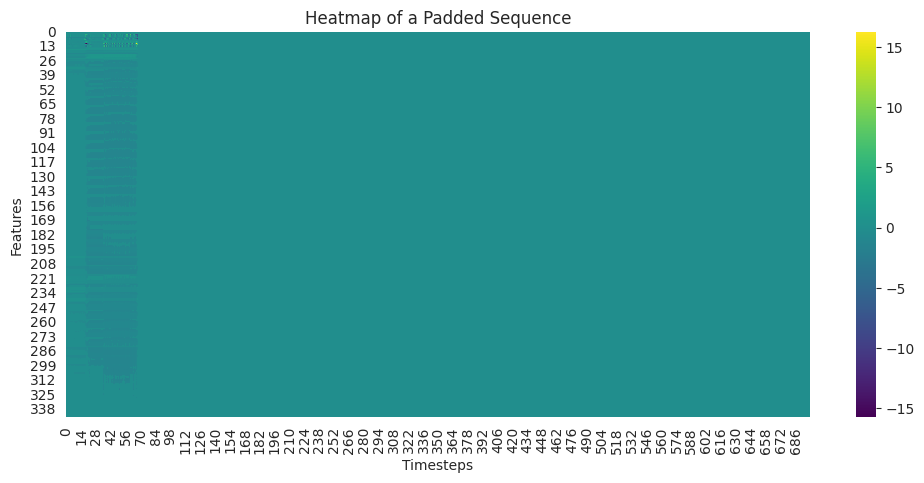

In [31]:
# select a sample to view (the first one)
sample_to_view = train_padded_ALL[1]

# create the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sample_to_view.T, cmap='viridis')
plt.title('Heatmap of a Padded Sequence')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()

## Model Training

In [32]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# initialize and fit encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ALL)
y_train = label_encoder.transform(y_train_ALL)
y_val = label_encoder.transform(y_val_ALL)

dummy_clf.fit(train_padded_ALL, y_train_ALL)

# predict on the validation set
y_val_pred_dummy = dummy_clf.predict(val_padded_ALL)

# calculate baseline accuracy
baseline_accuracy = accuracy_score(y_val_ALL, y_val_pred_dummy)
print(f"Baseline (Most Frequent) Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline (Most Frequent) Accuracy: 6.00%


In [33]:
# set variables
num_timesteps = 700 
num_features = 345
num_classes = 18

# define model
model_ALL = Sequential([
    
    # block 1 
    Input(shape=(num_timesteps, num_features)),
    Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 2 
    Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 3
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 4
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 5
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    
    # dense layers
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# compile model
model_ALL.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ALL.summary()

I0000 00:00:1764041762.879068      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764041762.879600      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 694, 128)       │       309,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 694, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 343, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 343, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 169, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 169, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 82, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 82, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 39, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             

 Total params: 2,286,738 (8.72 MB)

 Trainable params: 2,283,410 (8.71 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [34]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ALL)
y_train_encoded_ALL = label_encoder.transform(y_train_ALL)
y_val_encoded_ALL = label_encoder.transform(y_val_ALL)

print("Labels successfully encoded.")

Labels successfully encoded.


Training model...
Epoch 1/200


I0000 00:00:1764041782.825504     114 service.cc:148] XLA service 0x785f400262d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764041782.826575     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764041782.826592     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764041783.633972     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/198 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.0434 - loss: 14.9725

I0000 00:00:1764041792.635399     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.0676 - loss: 7.2603 - val_accuracy: 0.0619 - val_loss: 5.2725 - learning_rate: 0.0010
Epoch 2/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.0772 - loss: 5.2545 - val_accuracy: 0.1212 - val_loss: 4.9125 - learning_rate: 0.0010
Epoch 3/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1130 - loss: 4.8674 - val_accuracy: 0.1427 - val_loss: 4.4430 - learning_rate: 0.0010
Epoch 4/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1386 - loss: 4.4519 - val_accuracy: 0.2064 - val_loss: 4.1379 - learning_rate: 0.0010
Epoch 5/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1691 - loss: 4.1749 - val_accuracy: 0.2431 - val_loss: 3.8088 - learning_rate: 0.0010
Epoch 6/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1814 - loss: 3.8989 - val_accuracy: 0.2342 - val_loss: 3.6246 - learning_rate: 0.0010
Epoch 7/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1954 - loss: 3.6735

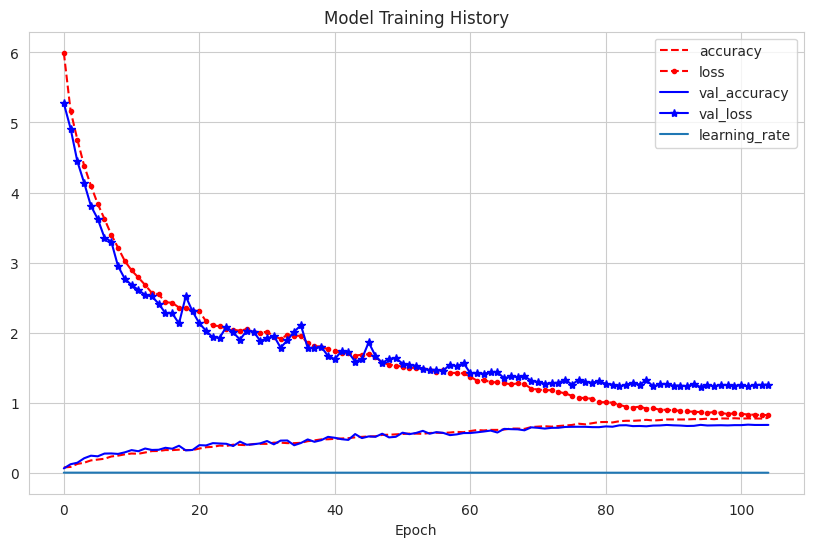

In [35]:
# define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7, verbose=1)

# train model!!!
print("Training model...")
history_ALL = model_ALL.fit(train_padded_ALL, y_train_encoded_ALL, epochs=200, batch_size=32, validation_data=(val_padded_ALL, y_val_encoded_ALL), callbacks=[early_stopping, reduce_lr])
print("Training complete.")

# plot train/val accuracy/loss
history_ALL_ = pd.DataFrame(history_ALL.history)
history_ALL_.plot(figsize=(10, 6), grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.title("Model Training History")
plt.show()

## Evaluation and Submission

In [36]:
# generate predictions
val_probabilities = model_ALL.predict(val_padded_ALL)
y_pred_val_ALL = np.argmax(val_probabilities, axis=1)
print("First 10 Validation Predictions:")
print(y_pred_val_ALL[:10])
print("\nFirst 10 True Validation Labels:")
print(y_val_encoded_ALL[:10])

# generate classification report for IMU-only features
gesture_names_int = label_encoder.classes_
gesture_names_str = [str(name) for name in gesture_names_int]
report = classification_report(y_val_encoded_ALL, y_pred_val_ALL, target_names=gesture_names_str)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
First 10 Validation Predictions:
[12  3 12  3  3  2  6  9  3 15]

First 10 True Validation Labels:
[15  9 12  0  3  2 11 10  4 15]
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.71      0.89      0.79       105
                        Cheek - pinch skin       0.61      0.62      0.61       133
                     Drink from bottle/cup       0.97      0.90      0.94        41
                       Eyebrow - pull hair       0.47      0.45      0.46       125
                       Eyelash - pull hair       0.55      0.56      0.55       133
Feel around in tray and pull out an object       1.00      1.00      1.00        23
                  Forehead - pull hairline       0.65      0.63      0.64       125
                        Forehead - scratch       0.65      0.72      0.68       135
                            Glasses on/off       0.90      0.87      0.8

In [42]:
LABELS = [
    'Above ear - pull hair',
    'Cheek - pinch skin',
    'Drink from bottle/cup',
    'Eyebrow - pull hair',
    'Eyelash - pull hair',
    'Feel around in tray and pull out an object',
    'Forehead - pull hairline',
    'Forehead - scratch',
    'Glasses on/off',
    'Neck - pinch skin',
    'Neck - scratch',
    'Pinch knee/leg skin',
    'Pull air toward your face',
    'Scratch knee/leg skin',
    'Text on phone',
    'Wave hello',
    'Write name in air',
    'Write name on leg'
]

In [46]:
import polars as pl

def process_single_sequence(df_seq: pd.DataFrame) -> np.ndarray:
    if isinstance(df_seq, pl.DataFrame):
        df_seq = df_seq.to_pandas()
    
    df_seq = df_seq.copy()

    # drop duplicate rows
    df_seq.drop_duplicates(inplace=True)

    # replace -1 and 0 with NaN in TOF columns
    tof_cols = [c for c in df_seq.columns if c.startswith('tof_')]
    if tof_cols:
        df_seq[tof_cols] = df_seq[tof_cols].replace([-1, 0], np.nan)

    # impute missing rot values with 0
    rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
    existing_rots = [c for c in rots if c in df_seq.columns]
    if existing_rots:
        df_seq[existing_rots] = df_seq[existing_rots].fillna(0)

    # fill missing temperature data with average by column (Constant 0 strategy)
    thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
    existing_thms = [c for c in thms if c in df_seq.columns]
    if existing_thms:
        df_seq[existing_thms] = df_seq[existing_thms].fillna(0)

    # fill all NaNs in time-of-flight (ToF) columns with 400
    if tof_cols:
        df_seq[tof_cols] = df_seq[tof_cols].fillna(400)

    # linear interpolation for missing acceleration data
    acc_cols = ["acc_x", "acc_y", "acc_z"]
    if all(c in df_seq.columns for c in acc_cols):
        df_seq[acc_cols] = df_seq[acc_cols].interpolate(method='linear', limit_direction='both')

    # drop unnecessary columns
    columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']
    df_seq = df_seq.drop(columns=[col for col in columns_to_drop if col in df_seq.columns])

    # calculate new features and concatenate
    new_features_df = calculate_sequence_features(df_seq)
    df_processed = pd.concat([df_seq, new_features_df], axis=1)
    
    # reorder columns
    NEW_IMU_FEATURES = [
        'lin_acc_x', 'lin_acc_y', 'lin_acc_z',
        'acc_mag', 'lin_acc_mag', 
        'acc_mag_jerk', 'lin_acc_mag_jerk', 
        'rot_angle', 'angular_distance', 'rot_angle_vel', 
        'angular_vel_x', 'angular_vel_y', 'angular_vel_z'
    ]
    
    id_cols = ['sequence_id']
    if 'gesture' in df_processed.columns:
        id_cols.append('gesture')
    
    original_cols = [
        col for col in df_processed.columns 
        if col not in id_cols and col not in NEW_IMU_FEATURES
    ]
    
    final_order = id_cols + NEW_IMU_FEATURES + original_cols
    final_order = [c for c in final_order if c in df_processed.columns]
    df_processed = df_processed[final_order]

    # scale features
    cols_to_exclude = ['sequence_id', 'gesture']
    cols_to_scale = [c for c in df_processed.columns if c not in cols_to_exclude]
    df_processed[cols_to_scale] = scaler.transform(df_processed[cols_to_scale])

    # pad sequence
    if 'sequence_id' in df_processed.columns:
        df_processed = df_processed.drop(columns=['sequence_id'])
    if 'gesture' in df_processed.columns:
        df_processed = df_processed.drop(columns=['gesture'])
    padded_sequences = pad_sequences([df_processed.values], padding='post', dtype='float32', maxlen=700)

    return padded_sequences

In [47]:
def predict(sequence: pd.DataFrame, demographics: pd.DataFrame) -> str:
    """
    The function called by the competition server for a single sequence.
    """
    # Preprocess
    # The API is serving Pandas or Polars; this ensures we use Pandas
    input_data = process_single_sequence(sequence)
    
    # Predict
    # The final model prediction
    prediction_probs = model_ALL.predict(input_data, verbose=0) 
    
    # Get the index of the highest probability (0-17)
    predicted_index = np.argmax(prediction_probs, axis=1)[0]
    
    # Map index back to the string label
    predicted_label = LABELS[predicted_index]
    
    return predicted_label

In [48]:
import kaggle_evaluation.cmi_inference_server

inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    # The official submission mode
    inference_server.serve()
else:
    # Local gateway for testing your code before submission
    inference_server.run_local_gateway(
        data_paths=(
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )

### TODO

- diagram(s) to display pre-processing, training, post-processing, etc.

Other ideas:
- mixup augmentation
- "attention score"
- post-processing/ accuracy evaluation condition (90% accuracy filter)
- "multi-head attention"

### Experimentation Log:
- tried Adam, AdamW and RMSprop optimizers, found AdamW had the best performance
- tried batch size 64 then went down to 32
- tried LSTM, GRU and got low performance, big jump when I used BatchNormalization and Dropout

- performance slightly worse with masking
- increasing dropout lowered performance
- adding L2 regularization gave a huge improvement to val_accuracy (~.48 with AdamW)
- tried both higher and lower ReduceLROnPlateau, slightly better performance with lower (0.3)
- tried 0.00001, 0.0001, 0.001, 0.01, and 0.0005 learning rates, found model gets stuck with rate 0.00001 and finishes too early with rate 0.01. Performs well with 0.0001 (.52), slightly better with 0.001 (.55) and 0.0005 (.55). Sticking with 0.001.
- tried l2 regularization strength 0.0001, 0.001, 0.01 and 0.1, found model gets stuck at (~.35) accuracy with 0.1, got slightly worse performance with 0.01 (~.44) and 0.0001 (~.49).

ALSO: talk about training IMU-only version, got slightly worse performance overall (show results) - better performance for 2-3 classes but decided against ensembling for memory's sake